# <center> How Good are UMD Professors? Or something </center>
CMSC320 Spring 2022 Final Project (Do we include this part?)

Andrew Zhong, James Wang, Jonah Leung

[PlanetTerp](https://planetterp.com/) is a course review website for the University of Maryland that aggregates user-submitted feedback for courses and professors at UMD. In addition to user-submitted reviews, professor and course information are retrieved from umd.io and grade data is retrieved from the UMD Office of Institutional Research, Planning & Assessment. 

Using the included [API](https://api.planetterp.com/), we retrieved course information and reviews to investigate the relationships between ratings and various factors.

## Data Collection

"Slug" is PlanetTerp's unique identifier for professors, since names may not be distinct.

### Course
Name | Type | Required | Restrictions | Description
--- | --- | --- | --- | --- |
department | string | true | none | none | 
course_number | string | true | none | none | 
title | string | true | none | none | 
description | string | true | none | none | 
credits | integer | true | none | none | 
professors | [string] | true | none | none | 
average_gpa | number | true | none | none | 

### Professor

Name | Type | Required | Restrictions | Description | 
--- | --- | --- | --- | --- | 
name | string | true | none | none | 
slug | string | true | none | none | 
type | string | true | none | none | 
courses | [string] | true | none | none | 
average_rating | number | true | none | none | 

### Grades

Name | Type | Required | Restrictions | Description | 
--- | --- | --- | --- | --- | 
course | string | true | none | none | 
professor | string | true | none | none | 
semester | string | true | none | none | 
section | string | true | none | none | 
A+ | integer | true | none | none | 
A | integer | true | none | none | 
A- | integer | true | none | none | 
B+ | integer | true | none | none | 
B | integer | true | none | none | 
B- | integer | true | none | none | 
C+ | integer | true | none | none | 
C | integer | true | none | none | 
C- | integer | true | none | none | 
D+ | integer | true | none | none | 
D | integer | true | none | none | 
D- | integer | true | none | none | 
F | integer | true | none | none | 
W | integer | true | none | none | 
Other | integer | true | none | none | 

Installing and importing required libraries, as well as defining some constants:

In [ ]:
try:
  import pandas as pd
  import numpy as np
  import requests
  import matplotlib.pyplot as plt
except:
  !pip install pandas numpy requests matplotlib
  import pandas as pd
  import numpy as np
  import requests
  import matplotlib.pyplot as plt

api_url = 'https://api.planetterp.com/v1'
min_reviews = 5

We use the requests module to create HTTP GET requests in order to retrieve data from the PlanetTerp API
Retrieving reviews and reformatting the request as a Pandas dataframe:

In [ ]:
# avoid making unnecessary API calls so we save to csv files after obtaining data
try:
  df_courses = pd.read_csv('courses.csv')
except FileNotFoundError:
  # get courses
  offset = 0
  df_courses = pd.DataFrame()
  while (True):
      response = requests.get(api_url + "/courses?&reviews=true&limit=1000&offset=" + str(offset))
      courses = response.json()
      if (len(courses) == 0):
          break
      df_courses = pd.concat([df_courses, pd.DataFrame(courses)], ignore_index=True)
      offset += 1000

  # filter only courses with a minimum number of reviews
  df_courses["review_count"] = df_courses["reviews"].apply(lambda x: len(x))
  df_courses = df_courses[df_courses["review_count"] >= min_reviews]
  df_courses = df_courses.replace(r'(\r\n)|\r|\n',' ', regex=True) # remove newlines
  df_courses = df_courses.replace("\"", "", regex=True) # remove quotes

  df_courses.to_csv('courses.csv', index=False)

try:
  df_profs = pd.read_csv('professors.csv')
except FileNotFoundError:
  offset = 0
  df_profs = pd.DataFrame()
  while (True):
      response = requests.get(api_url + "/professors?type=professor&reviews=true&limit=1000&offset=" + str(offset))
      professors = response.json()
      if (response.status_code != 200 or len(professors) == 0):
          break
      df_profs = pd.concat([df_profs, pd.DataFrame(professors)], ignore_index=True)
      offset += 1000

  # filter only professors with a minimum number of reviews
  df_profs["review_count"] = df_profs["reviews"].apply(lambda x: len(x))
  df_profs = df_profs[df_profs["review_count"] >= min_reviews]
  df_courses = df_courses.replace(r'(\r\n)|\r|\n',' ', regex=True) # remove newlines
  df_profs = df_profs.replace("\"", "", regex=True) # remove quotes

  df_profs.to_csv('professors.csv', index=False)

try:
  df_grades_full = pd.read_csv('grades.csv')
except FileNotFoundError:
  df_grades_full = pd.DataFrame()
  for p in df_profs["name"]:
      response = requests.get(api_url + "/grades?professor=" + p)
      grades = response.json()
      if (response.status_code != 200):
          break
      df_grades_full = pd.concat([df_grades_full, pd.DataFrame(grades)], ignore_index=True)

  df_grades_full.to_csv('grades.csv', index=False)

print("loaded " + str(len(df_profs)) + " professors and " + str(len(df_courses)) + " courses")

loaded 867 professors and 570 courses


It's difficult to make a judgement on professors with very few reviews. Since we had to fetch grade data one at a time by professor, we already filtered out all professors with less reviws under a minimum threshold from the dataframe and used those to fetch grades. Courses with few reviews are also difficult to use to gauge a professors, so we've filtered our results by a similar minimum review threshold. We'll go with 5, and change it if necessary.

We've created a 'reviews_count' column for both the professors and courses dataframes for convenience and later analysis. Now lets look at the three dataframes we've created from the PlanetTerp API

In [ ]:
df_courses.head(3)

,department,course_number,title,description,credits,professors,average_gpa,reviews,review_count
1,AASP,100,Introduction to African American Studies,Significant aspects of the history of African ...,3.0,"[Jason Nichols, Jonathan England, Shane Walsh,...",3.21722,"[{'professor': 'Jonathan England', 'course': '...",29
2,AASP,100H,Introduction to African American Studies,Significant aspects of the history of African ...,3.0,"[Jonathan England, Shane Walsh, George Kintiba...",3.16167,"[{'professor': 'Jonathan England', 'course': '...",5
3,AASP,101,Public Policy and the Black Community,<b>Formerly:</b> AASP300. The impact of public...,3.0,"[Jonathan England, Gniesha Dinwiddie, Alana Ha...",3.22089,"[{'professor': 'Jonathan England', 'course': '...",7


In [ ]:
df_profs.head(3)

,name,slug,type,courses,reviews,average_rating,review_count
3,A Sharma,sharma_a,professor,[ASTR300],"[{'professor': 'A Sharma', 'course': 'ASTR300'...",1.80,5
5,A.U. Shankar,shankar_a.u.,professor,"[CMSC412, CMSC414, CMSC712, CMSC216, CMSC798]","[{'professor': 'A.U. Shankar', 'course': 'CMSC...",2.44,25
26,Aaron Swanlek,swanlek,professor,[COMM107],"[{'professor': 'Aaron Swanlek', 'course': 'COM...",5.00,9


In [ ]:
df_grades_full.head(3)

,course,professor,semester,section,A+,A,A-,B+,B,B-,C+,C,C-,D+,D,D-,F,W,Other
0,ASTR300,A Sharma,201901,0101,0,8,5,5,16,5,4,8,4,0,2,0,0,3,1
1,ASTR300,A Sharma,201808,0101,0,3,6,4,11,5,4,10,2,0,0,0,2,4,2
2,ASTR300,A Sharma,201801,0101,0,14,15,10,9,2,2,1,2,2,1,0,0,0,0


In [ ]:
# avg_course_ratings = []
# for course in df_courses['reviews']:
#   s, n = 0, 0
#   for review in course:
#     s += review['rating']
#     n += 1
#   avg_course_ratings.append(s/n)
# avg_course_ratings = np.array(avg_course_ratings)
# print(f"Mean course rating: {np.mean(avg_course_ratings)}")

Mean course rating: 3.693824670214398


Currently, the grades dataframe has a separate row for each course, professor, and semester, and section combination. For our purposes, we will not need to worry about differentiating separate semesters, and especially section. We combine the rows with the same course and professor, summing up the counts for letter grades. We also create a "total" column that sums up how many letter grades are in each row and a "credits" column with each course's credits obtained from df_courses. We then combine the rows again if they share a professor, to have a dataframe the contains a row for each professor. GPA is another metric we will look at, so we create this column too.

In [ ]:
letter_grades = ["A+","A","A-","B+","B","B-","C+","C","C-","D+","D","D-","F"]
letter_weights = [4.0,4.0,3.7,3.3,3.0,2.7,2.3,2.0,1.7,1.3,1.0,0.7,0.0]
credits_lookup = {}
for i in range(len(df_courses)):
    credits_lookup[df_courses.iloc[i]["department"] + df_courses.iloc[i]["course_number"]] = df_courses.iloc[i]["credits"]

# filter out courses not in df_courses
df_grades = df_grades_full[df_grades_full["course"].isin(credits_lookup)]

# create column for total number of letter grades
df_grades["total"] = df_grades[letter_grades].sum(axis=1)
# combine rows with same course and professor
df_grades = df_grades[["course", "professor"] + letter_grades + ["W", "Other", "total"]].groupby(["course", "professor"]).sum().reset_index()


# change NaN to 0 in "credits" column and type to int
df_courses["credits"] = df_courses["credits"].fillna(0).astype(int)
# create "credits" column in df_grades from "credits" column in df_courses
df_grades["credits"] = df_grades["course"].map(credits_lookup)
# combine rows with same professor
df_grades_profs = df_grades.groupby(["professor"]).sum().reset_index()
# calculate GPA
df_grades_profs["GPA"] = df_grades[letter_grades].apply(lambda letters: np.dot(letters.values, letter_weights), axis=1) / df_grades["total"]

df_grades_profs.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,professor,A+,A,A-,B+,B,B-,C+,C,C-,D+,D,D-,F,W,Other,total,credits,GPA
0,A Sharma,1,34,37,42,67,28,13,26,12,4,4,1,3,13,4,272,3,3.760000
1,A.U. Shankar,58,112,76,77,154,67,60,113,72,0,54,1,78,93,135,922,11,3.161107
2,Aaron Swanlek,272,65,24,10,1,4,1,1,0,0,0,0,1,4,1,379,3,3.130192
3,Abram Kagan,0,54,17,0,36,11,0,25,9,0,1,0,5,18,3,158,6,3.940000
4,Adam Hsieh,13,112,73,72,63,70,39,17,24,4,2,0,4,12,0,493,6,3.718750


We can now combine this dataframe with df_profs, since they both just have one row per professor.

In [ ]:
# join df_grades_profs with df_profs
print(len(df_grades_profs), len(df_profs))

df_profs2 = pd.merge(df_profs, df_grades_profs.rename(columns={"professor":"name"}), on="name")
df_profs2 = df_profs2.drop(columns=["slug", "type", "courses", "reviews"])
df_profs2.head()

779 867


,name,average_rating,review_count,bayesian_avg,A+,A,A-,B+,B,B-,...,C-,D+,D,D-,F,W,Other,total,credits,GPA
0,A Sharma,1.8000,5,2.371429,1,34,37,42,67,28,...,12,4,4,1,3,13,4,272,3,3.760000
1,A.U. Shankar,2.4400,25,2.540741,58,112,76,77,154,67,...,72,0,54,1,78,93,135,922,11,3.161107
2,Aaron Swanlek,5.0000,9,4.781818,272,65,24,10,1,4,...,0,0,0,0,1,4,1,379,3,3.130192
3,Abram Kagan,2.7000,10,2.883333,0,54,17,0,36,11,...,9,0,1,0,5,18,3,158,6,3.940000
4,Adam Hsieh,3.8889,9,3.872736,13,112,73,72,63,70,...,24,4,2,0,4,12,0,493,6,3.718750


## Exploratory stuff?
distributions of average rating and review counts

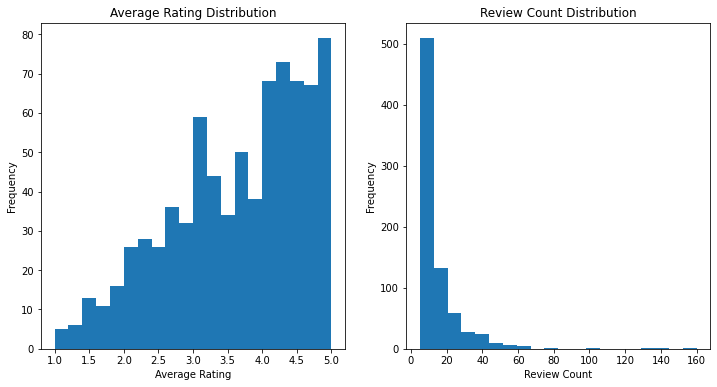

In [ ]:
# create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# plot distribution average rating
ax1.hist(df_profs2["average_rating"], bins=20)
ax1.set_title("Average Rating Distribution")
ax1.set_xlabel("Average Rating")
ax1.set_ylabel("Frequency")

# plot distribution of review count
ax2.hist(df_profs2["review_count"], bins=20)
ax2.set_title("Review Count Distribution")
ax2.set_xlabel("Review Count")
ax2.set_ylabel("Frequency")

# show the plots
plt.show()

## Best Professors

Things to look at?
* number of classes (say with minimum 5 reviews) vs rating
* average gpa of classes vs rating

The most straightforward approach we could take to figuring out the best professor is just sorting by ratings.

In [ ]:
# sort professors by rating
df_profs2.sort_values(by=["average_rating"], ascending=False).head(10)

,name,average_rating,review_count,bayesian_avg,A+,A,A-,B+,B,B-,...,C-,D+,D,D-,F,W,Other,total,credits,GPA
73,Ashley Aragon,5.0,7,4.733333,100,38,16,4,5,2,...,0,0,1,1,1,2,0,170,3,2.905336
229,Eric Luedtke,5.0,7,4.733333,193,153,74,43,22,9,...,3,0,0,2,10,14,6,523,6,3.048000
107,Caroline Rothrock,5.0,8,4.760000,16,48,21,3,5,2,...,0,0,1,0,2,5,5,104,9,3.057078
105,Carmen Cantemir-Stone,5.0,7,4.733333,76,155,69,48,85,21,...,12,3,3,1,4,20,2,516,4,2.875647
33,Amanda Hall,5.0,6,4.700000,310,94,50,5,7,4,...,1,0,0,0,2,12,0,481,3,2.920877
68,Aric Bills,5.0,8,4.760000,104,157,73,36,52,39,...,12,10,3,2,19,31,54,551,6,3.937975
36,Amelia Branigan,5.0,7,4.733333,185,235,91,27,25,15,...,2,5,6,0,8,23,19,616,3,3.971111
98,Bruce Jacob,5.0,7,4.733333,48,68,36,25,12,1,...,3,0,2,0,2,9,0,209,5,3.085714
40,Amr Baz,5.0,11,4.815385,39,397,55,83,154,17,...,16,0,1,0,3,11,20,829,9,3.770445
41,Amy Fisher,5.0,5,4.657143,393,606,150,47,26,11,...,0,1,2,0,3,20,4,1249,3,3.394172


Unsurprisingly, we see most all of the top 10 being  professors with a relatively small number of reviews. These professors might just not had enough reviews written for them to get their first non 5-star review. One approach to counteract this is using a Bayesian average, which is used to estimate the real average by using outside information. We can introduce "dummy reviews" to all of the professors with the average rating among all professors, and recalculate the average. The Bayesian average for all professors will be slightly closer to the average rating, but impacts professors with a high review count much less than one with a low review count. We can try adding one dummy review first.

In [ ]:
# average rating median
avg = df_profs2["average_rating"].median()
print("Median average rating: " + str(avg))

# add a dummy reviews with the average rating and get the new average rating
df_profs2["bayesian_avg"] = (df_profs2["average_rating"] * df_profs2["review_count"] + avg) / (df_profs2["review_count"] + 1)
df_profs2.sort_values(by=["bayesian_avg"], ascending=False).head(10)

Median average rating: 3.8182


,name,average_rating,review_count,bayesian_avg,A+,A,A-,B+,B,B-,...,C-,D+,D,D-,F,W,Other,total,credits,GPA
495,Michael Galczynski,4.9773,44,4.951542,225,686,143,137,122,28,...,5,1,5,0,18,29,44,1420,15,2.722556
255,George Kurtzweil,5.0000,14,4.921213,62,340,57,24,10,3,...,0,0,0,0,0,9,7,496,3,3.118868
164,David Brookshire,5.0000,14,4.921213,46,638,280,120,77,44,...,11,1,0,0,34,28,27,1269,6,3.144845
679,Stefan Doboszczak,4.9565,23,4.909071,118,241,176,132,139,100,...,29,25,28,9,43,70,162,1150,28,3.267708
40,Amr Baz,5.0000,11,4.901517,39,397,55,83,154,17,...,16,0,1,0,3,11,20,829,9,3.770445
386,Justin Wyss-Gallifent,4.9063,160,4.899542,4362,3178,1041,555,1290,507,...,220,46,200,46,289,658,187,12562,33,3.229819
49,Andrew Schonebaum,5.0000,10,4.892564,0,239,61,34,28,12,...,0,0,0,0,4,8,23,385,3,3.523684
720,Thomas Murphy,5.0000,10,4.892564,35,147,75,59,112,69,...,28,8,20,9,22,52,49,675,4,3.423358
653,Samuel Handwerger,5.0000,10,4.892564,25,354,319,301,289,105,...,7,0,2,0,3,20,40,1454,24,3.130000
646,Ryan Smith,5.0000,10,4.892564,94,101,41,32,20,10,...,2,0,1,1,7,14,13,319,2,1.955738


We see that half the professors in this top ten has 10 or 11 total reviews, which still seems too little to be ranked this high. What happens if we add two reviews?

In [ ]:
df_profs2["bayesian_avg"] = (df_profs2["average_rating"] * df_profs2["review_count"] + avg * 2) / (df_profs2["review_count"] + 2)
df_profs2.sort_values(by=["bayesian_avg"], ascending=False).head(10)

,name,average_rating,review_count,bayesian_avg,A+,A,A-,B+,B,B-,...,C-,D+,D,D-,F,W,Other,total,credits,GPA
495,Michael Galczynski,4.9773,44,4.926904,225,686,143,137,122,28,...,5,1,5,0,18,29,44,1420,15,2.722556
386,Justin Wyss-Gallifent,4.9063,160,4.892867,4362,3178,1041,555,1290,507,...,220,46,200,46,289,658,187,12562,33,3.229819
679,Stefan Doboszczak,4.9565,23,4.865436,118,241,176,132,139,100,...,29,25,28,9,43,70,162,1150,28,3.267708
164,David Brookshire,5.0000,14,4.852275,46,638,280,120,77,44,...,11,1,0,0,34,28,27,1269,6,3.144845
255,George Kurtzweil,5.0000,14,4.852275,62,340,57,24,10,3,...,0,0,0,0,0,9,7,496,3,3.118868
40,Amr Baz,5.0000,11,4.818185,39,397,55,83,154,17,...,16,0,1,0,3,11,20,829,9,3.770445
370,Jose Calderon,4.8846,26,4.808429,246,134,137,108,106,84,...,40,11,12,9,16,62,43,1007,10,3.236333
646,Ryan Smith,5.0000,10,4.803033,94,101,41,32,20,10,...,2,0,1,1,7,14,13,319,2,1.955738
653,Samuel Handwerger,5.0000,10,4.803033,25,354,319,301,289,105,...,7,0,2,0,3,20,40,1454,24,3.130000
720,Thomas Murphy,5.0000,10,4.803033,35,147,75,59,112,69,...,28,8,20,9,22,52,49,675,4,3.423358


We start to see more professors with a higher review count, which more closely matches our intuition for picking the best professors.

Let's see how courses a professor taught and the average GPA affects their Bayesian average rating.

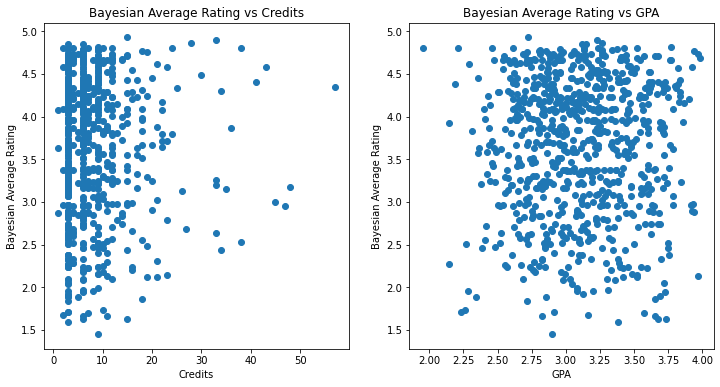

In [26]:
# create two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
# plot bayesian average vs credits
ax1.scatter(df_profs2["credits"], df_profs2["bayesian_avg"])
ax1.set_title("Bayesian Average Rating vs Credits")
ax1.set_xlabel("Credits")
ax1.set_ylabel("Bayesian Average Rating")
# linear regression TODO


# plot bayesian average vs GPA
ax2.scatter(df_profs2["GPA"], df_profs2["bayesian_avg"])
ax2.set_title("Bayesian Average Rating vs GPA")
ax2.set_xlabel("GPA")
ax2.set_ylabel("Bayesian Average Rating")
# linear regression line TODO

# show
plt.show()

> Checking for repeat values




In [27]:
df3 = df_courses.dropna()
df3['title+course_number'] = df3['course_number'].astype(str) +"-"+ df3["title"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
len(pd.unique(df3['title+course_number']))

553

In [29]:
df3[df3.duplicated(['title+course_number'], keep=False)]

,department,course_number,title,description,credits,professors,average_gpa,reviews,review_count,title+course_number
4109,CMSC,456,Cryptography,"<b>Prerequisite:</b> (CMSC106, CMSC131, or ENE...",3,"[Jonathan Katz, James Schafer, Lawrence Washin...",2.36667,"[{'professor': 'Jonathan Katz', 'course': 'CMS...",21,456-Cryptography
6199,ENAE,202,Computing Fundamentals for Engineers,<b>Corequisite:</b> Must be concurrently enrol...,3,"[Robert Sanner, Johan Larsson, Abhijit Dasgupt...",2.81918,"[{'professor': 'Robert Sanner', 'course': 'ENA...",18,202-Computing Fundamentals for Engineers
7573,ENME,202,Computing Fundamentals for Engineers,<b>Corequisite:</b> Must be concurrently enrol...,3,"[Johan Larsson, Robert Sanner, Don DeVoe, Abhi...",2.90437,"[{'professor': 'Johan Larsson', 'course': 'ENM...",7,202-Computing Fundamentals for Engineers
12757,MATH,456,Cryptography,"<b>Prerequisite:</b> (CMSC106, CMSC131, or ENE...",3,"[James Schafer, Lawrence Washington, Jonathan ...",2.99110,"[{'professor': 'Lawrence Washington', 'course'...",6,456-Cryptography
17290,WGSS,250,Introduction to WGSS: Art and Culture,<b>Credit only granted for:</b> WMST250 or WGS...,3,"[Taylor York, Kate Yanchulis, Sarah Scriven, M...",3.68652,"[{'professor': 'Sina Lee', 'course': 'WGSS250'...",6,250-Introduction to WGSS: Art and Culture
17332,WMST,250,Introduction to WGSS: Art and Culture,<b>Credit only granted for:</b> WMST250 or WGS...,3,"[Katie King, Renina Jarmon, Catherine Schuler,...",3.52552,"[{'professor': 'Deborah Rosenfelt', 'course': ...",20,250-Introduction to WGSS: Art and Culture



> We see that, upon organizing our data by course number and name, that there are repeats! The repeated classes are those that cross lines between different academic disciplines, but since they are technically two different classes, we decided to keep them in the dataset instead of removing the duplicates.

In [30]:
tempa = []
for temp in df_courses['average_gpa']:
    tempa.append(temp)
print(tempa)

[3.21722, 3.16167, 3.22089, 3.36021, 3.0099, 2.3, 3.88683, 3.17934, 2.94044, 2.97769, 2.80508, 3.25633, 3.2892, 3.31727, 2.55084, 3.80413, 2.08828, 3.22133, 3.08097, 3.22068, 3.5092, 3.6453, 3.29092, 3.22608, 3.05917, 2.90788, 2.83879, 3.05106, 3.0352, 2.80633, 2.87275, 3.38591, 2.80397, 2.79082, 2.74171, 2.99226, 2.8668, 3.22866, 3.32131, 3.09562, 3.37301, 3.57728, 2.68909, 2.88717, 2.71959, 3.28993, 2.81883, 2.82124, 2.8319, 3.22204, 2.64992, 2.70687, 2.59563, 2.79611, 2.99779, 3.10019, 3.38684, 2.92027, 2.75663, 3.1657, 3.20668, 3.13975, 3.59747, 3.59422, 2.91772, 3.27377, 3.22261, 2.40444, 2.86114, 2.54952, 2.89627, 3.20362, 3.48693, 3.35817, 3.50391, 3.222, 3.17204, 3.26074, 2.79581, 2.89603, 3.25493, 3.41524, 2.99083, 3.32254, 3.42387, 2.89004, 2.92098, 3.35948, 3.22763, 3.46887, 3.13921, 3.38309, 3.45194, 3.51988, 3.39048, 3.22435, 2.92802, 3.41047, 3.23695, 2.88656, 3.87607, 3.32094, 3.50649, 3.62264, 3.31806, 3.17086, 2.97521, 3.36989, 3.48206, 3.62686, 3.50855, 3.3908, 3.3969

In [31]:
#tempa = []
#for temp in df['average_gpa']:
#    tempa.append(temp)
plt.scatter(tempa, avg_course_ratings, label='Scatter Plot')
    #plt.plot(x,y, color='red', label='Regression Line')
plt.xlabel('Average GPA')
plt.ylabel('Reviews')
plt.title('Average GPA vs Reviews')
    #plt.legend(['Slope: ' + str(b1)])
    # Setting axis to the same number so that the slope line is easier to
    # interpret
    #plt.xlim(0, max(int(max_x), int(max_y)))
    #plt.ylim(0, max(int(max_x), int(max_y)))
plt.show()
plt.clf()
    

NameError: ignored

> Now that we have a visualization, we can try to further enhance it with a regression model



Let's try to see if we get a clearer trend when we split courses into departments. Since there are so many unique departments, let's just look at the ones that we care about for now :).

In [32]:
len(pd.unique(df_courses['department']))

86

In [33]:
targets = ['CMSC', 'MATH', 'ENGL', 'BMGT', 'HACS', 'ENES', 'BCHM']

data_per_class = []
for dep in targets:
  data_per_class.append(df3[df3['department'] == dep])